# Pràctica 3 - PLH

### Realitzada pels alumnes Lluc Furriols i Pau Prat Moreno

In [59]:
'''
import os 
f = open("/dev/null", "w")
os.dup2(f.fileno(), 2)
f.close()

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()
'''

'\nimport os \nf = open("/dev/null", "w")\nos.dup2(f.fileno(), 2)\nf.close()\n\nimport nltk\nimport ssl\n\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\nnltk.download()\n'

In [60]:
import nltk
nltk.download('punkt', quiet=True) # Tokenitzador
nltk.download('averaged_perceptron_tagger', quiet=True) # Etiquetador POS
nltk.download('maxent_ne_chunker', quiet=True) # Etiquetador Entitats Anomenades
nltk.download('words', quiet=True)

True

In [61]:
# Fet pel profe a la pissarra
'''
class FeatureGetter:
    def __init__(ws_cap, ws_prefix,...):
        self.ws_cap = ws_cap
        self.ws_prefix = ws_prefix
        ...
    def __call__(self, token, idx):
        pass
getter_1 = FeatureGetter(ws_cap=True, ws_prefix=False, ...)
'''

'\nclass FeatureGetter:\n    def __init__(ws_cap, ws_prefix,...):\n        self.ws_cap = ws_cap\n        self.ws_prefix = ws_prefix\n        ...\n    def __call__(self, token, idx):\n        pass\ngetter_1 = FeatureGetter(ws_cap=True, ws_prefix=False, ...)\n'

In [62]:
nltk.download('conll2002')
from nltk.corpus import conll2002

train_esp = conll2002.iob_sents('esp.train') # Train, 
val_esp = conll2002.iob_sents('esp.testa') # Val
test_esp = conll2002.iob_sents('esp.testb') # Test

train_ned = conll2002.iob_sents('ned.train') # Train
val_ned = conll2002.iob_sents('ned.testa') # Val
test_ned = conll2002.iob_sents('ned.testb') # Test

# Convertir token postag classe --> postag classe (crec, ha dit 2)

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\llucfurriols\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [63]:
train_esp

[[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')], [('-', 'Fg', 'O')], ...]

In [64]:
"""def feature_func(tokens, idx):
    
    Feature function for CRF NER
    :param tokens: a list of tuples, each tuple containing (word, pos, iob_tag)
    :param idx: the index of the word
    
    # Inicialitzar el diccionari de característiques
    word, pos, iob_tag = tokens[idx]
    features = {
        'word': word,
        'word.lower()': word.lower(),
        'is_first': idx == 0,
        'is_last': idx == len(tokens) - 1,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0] if len(word) > 0 else '',
        'prefix-2': word[:2] if len(word) > 1 else '',
        'prefix-3': word[:3] if len(word) > 2 else '',
        'suffix-1': word[-1] if len(word) > 0 else '',
        'suffix-2': word[-2:] if len(word) > 1 else '',
        'suffix-3': word[-3:] if len(word) > 2 else '',
        'prev_word': '' if idx == 0 else tokens[idx - 1][0],
        'next_word': '' if idx == len(tokens) - 1 else tokens[idx + 1][0],
        'has_hyphen': '-' in word,
        'is_numeric': word.isdigit(),
        'pos': pos,
        'pos_prefix-2': pos[:2],
        'pos_prefix-3': pos[:3],
        'iob_tag': iob_tag
    }
    
    # Característiques de la paraula anterior
    if idx > 0:
        prev_word, prev_pos, prev_iob_tag = tokens[idx - 1]
        features.update({
            'prev_word': prev_word,
            'prev_word.lower()': prev_word.lower(),
            'prev_word.is_capitalized': prev_word[0].upper() == prev_word[0],
            'prev_pos': prev_pos,
            'prev_iob_tag': prev_iob_tag
        })
    else:
        features['BOS'] = True  # Indicador de començament de sentència
    
    # Característiques de la paraula següent
    if idx < len(tokens) - 1:
        next_word, next_pos, next_iob_tag = tokens[idx + 1]
        features.update({
            'next_word': next_word,
            'next_word.lower()': next_word.lower(),
            'next_word.is_capitalized': next_word[0].upper() == next_word[0],
            'next_pos': next_pos,
            'next_iob_tag': next_iob_tag
        })
    else:
        features['EOS'] = True  # Indicador de final de sentència

    return features
"""

"def feature_func(tokens, idx):\n    \n    Feature function for CRF NER\n    :param tokens: a list of tuples, each tuple containing (word, pos, iob_tag)\n    :param idx: the index of the word\n    \n    # Inicialitzar el diccionari de característiques\n    word, pos, iob_tag = tokens[idx]\n    features = {\n        'word': word,\n        'word.lower()': word.lower(),\n        'is_first': idx == 0,\n        'is_last': idx == len(tokens) - 1,\n        'is_capitalized': word[0].upper() == word[0],\n        'is_all_caps': word.upper() == word,\n        'is_all_lower': word.lower() == word,\n        'prefix-1': word[0] if len(word) > 0 else '',\n        'prefix-2': word[:2] if len(word) > 1 else '',\n        'prefix-3': word[:3] if len(word) > 2 else '',\n        'suffix-1': word[-1] if len(word) > 0 else '',\n        'suffix-2': word[-2:] if len(word) > 1 else '',\n        'suffix-3': word[-3:] if len(word) > 2 else '',\n        'prev_word': '' if idx == 0 else tokens[idx - 1][0],\n       

In [65]:
"""def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in train_esp]
y_train = [sent2labels(s) for s in train_esp]

X_test = [sent2features(s) for s in test_esp]
y_test = [sent2labels(s) for s in test_esp]"""

"def word2features(sent, i):\n    word = sent[i][0]\n    postag = sent[i][1]\n\n    features = {\n        'bias': 1.0,\n        'word.lower()': word.lower(),\n        'word[-3:]': word[-3:],\n        'word.isupper()': word.isupper(),\n        'word.istitle()': word.istitle(),\n        'word.isdigit()': word.isdigit(),\n        'postag': postag,\n        'postag[:2]': postag[:2],\n    }\n    if i > 0:\n        word1 = sent[i-1][0]\n        postag1 = sent[i-1][1]\n        features.update({\n            '-1:word.lower()': word1.lower(),\n            '-1:word.istitle()': word1.istitle(),\n            '-1:word.isupper()': word1.isupper(),\n            '-1:postag': postag1,\n            '-1:postag[:2]': postag1[:2],\n        })\n    else:\n        features['BOS'] = True\n\n    if i < len(sent)-1:\n        word1 = sent[i+1][0]\n        postag1 = sent[i+1][1]\n        features.update({\n            '+1:word.lower()': word1.lower(),\n            '+1:word.istitle()': word1.istitle(),\n          

In [66]:
test_esp

[[('La', 'DA', 'B-LOC'), ('Coruña', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')], [('-', 'Fg', 'O')], ...]

In [67]:
def getfeatures(doc):
    return [[((word, pos), iob) for word, pos, iob in sent] for sent in doc]

In [68]:
def quitpostag(doc):
    return [[(word, iob) for word, pos, iob in sent] for sent in doc]

In [69]:
#%pip install sklearn-pycrfsuite

In [70]:
#%pip install python-crfsuite

[('Melbourne', 'B-LOC'), ('(', 'O'), ('Australia', 'B-LOC'), (')', 'O'), (',', 'O'), ('25', 'O'), ('may', 'O'), ('(', 'O'), ('EFE', 'B-ORG'), (')', 'O'), ('.', 'O')]
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']


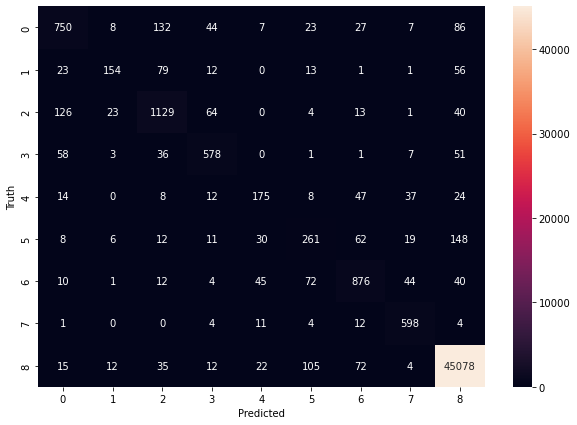

              precision    recall  f1-score   support

       B-LOC       0.75      0.69      0.72      1084
      B-MISC       0.74      0.45      0.56       339
       B-ORG       0.78      0.81      0.79      1400
       B-PER       0.78      0.79      0.78       735
       I-LOC       0.60      0.54      0.57       325
      I-MISC       0.53      0.47      0.50       557
       I-ORG       0.79      0.79      0.79      1104
       I-PER       0.83      0.94      0.88       634
           O       0.99      0.99      0.99     45355

    accuracy                           0.96     51533
   macro avg       0.76      0.72      0.73     51533
weighted avg       0.96      0.96      0.96     51533



0.9624706498748374

In [72]:
from nltk.tag import CRFTagger
import pycrfsuite

ct = CRFTagger(feature_func=None)
#train and test sets without the postag
train_esp_bio = quitpostag(train_esp)
test_esp_bio = quitpostag(test_esp)
print(train_esp_bio[0])

#y_test is the true labels
y_test = [[iob for word, iob in sent] for sent in test_esp_bio]
print(y_test[0])

#train the model
ct.train(train_esp_bio, 'model.crf.tagger')

#predict the labels
y_pred = ct.tag_sents([[word for word, iob in sent] for sent in test_esp_bio])
y_pred = [[iob for word, iob in sent] for sent in y_pred]
print(y_pred[0])


#show the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Flatten y_test and y_pred
y_test_flat = [iob for sent in y_test for iob in sent]
y_pred_flat = [iob for sent in y_pred for iob in sent]

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Visualize confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#show the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_flat, y_pred_flat))
ct.accuracy(test_esp_bio)